# 5DEEP

## LARIBIERE Bruno 298261

Ce sujet a pour but d'apprendre et reconnaitre des animaux sur une image grâce à des algorithme de deep learning. J'utiliserai keras afin d'y parvenir

## Installation

## Initialisation des variables

In [1]:
import pathlib
from pathlib import Path
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, experimental, Activation, BatchNormalization
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import ntpath
import random
import tensorflow as tf
import os
from os import path
import shutil
import numpy as np
import zipfile

# Image class definition
class_names = ['0_cat', '1_lynx', '2_wolf', '3_coyote', '4_cheetah', '5_jaguer', '6_chimpanzee', '7_orangutan', '8_hamster', '9_guinea pig']

## CONFIGURATION

In [2]:
trainModel = True # Si true, entrainera le modèle à l'execution de la feuille, si False utilisera le modèle sauvegardé

trainEpoch = 50 # Nombre d'epoch d'entrainement, utile seulement si trainModel = true, peut être arrêté automatiquement 
# avant si pas d'amélioration sur le modèle

skipImgSize = False # Evite la verification des tailles des images, permet de gagner du temps.

saveModel = True # Si true, le nouveau modèle entrainé sera sauvegardé, supprimant ainsi l'ancien

## Cuda driver

Vérification de la présence des drivers CUDA pour Nvidia afin d'accélérer les calculs. Ceci est optionnel.

In [3]:
# Tool to check CUDA install success
if tf.test.gpu_device_name(): 
    print('GPU found ! Compute will run over GPU.'.format(tf.test.gpu_device_name()))
else:
   print("Can't compute with CUDA, TF will run over CPU")

GPU found ! Compute will run over GPU.


## Pré traitement des images

In [4]:
##Fonction permettant de déduire une catégorie depuis la localisation de l'image

def imageToCat(imagePath):
    filename = ntpath.basename(imagePath)
    category = filename.split("_")[0]
    return class_names[int(category)]

### Extraction du ZIP

In [5]:
if not path.exists("./assets/raw_image/") and not path.exists("./assets/ordered_image/"):
    with zipfile.ZipFile("./assets/raw_image.zip", 'r') as zip_ref:
        zip_ref.extractall("./assets/raw_image")
    print("All images extracted !")
else: 
    print("Abort zip extract, already extracted")

All images extracted !


### Organisation par catégorie

In [6]:
if not path.exists("./assets/ordered_image/train"):
    imageList = list(pathlib.Path("./assets/raw_image/training/").glob('*.jpg'))
    Path("./assets/ordered_image/train").mkdir(parents=True, exist_ok=True)
    
    for f in list(class_names):
        Path("./assets/ordered_image/train/"+f).mkdir(parents=True, exist_ok=True)
        
    
    for f in list(imageList):
        category = imageToCat(f)
        destination = Path("./assets/ordered_image/train/"+category)
        shutil.move(os.fspath(f),os.fspath(destination))  

else:
    print("Train image already ordered, skiped step")
        
        
if not path.exists("./assets/ordered_image/test"):
    imageListTest = list(pathlib.Path("./assets/raw_image/testing/").glob('*.jpg'))
    Path("./assets/ordered_image/test").mkdir(parents=True, exist_ok=True)
    
    for f in list(class_names):
        Path("./assets/ordered_image/test/"+f).mkdir(parents=True, exist_ok=True)

    for f in list(imageListTest):
        category = imageToCat(f)
        destination = Path("./assets/ordered_image/test/"+category)
        shutil.move(os.fspath(f),os.fspath(destination))
        
else:
    print("Test image already ordered, skiped step")
  
if path.exists("./assets/raw_image/"):
       shutil.rmtree("./assets/raw_image/")

## Vérification des images

### Nombre d'image

In [7]:
trainImages = []
testImages = []

for f in list(class_names):
    assetTrain = pathlib.Path("./assets/ordered_image/train/"+f)
    assetTest = pathlib.Path("./assets/ordered_image/test/"+f)
    
    imageList = list(assetTrain.glob('*.jpg'))
    imageListTest = list(assetTest.glob('*.jpg'))

    trainImages = trainImages + imageList
    testImages = testImages + imageListTest


if len(trainImages) == 50000 and len(testImages) == 5000 :
    print(f"Total d'image destinées à l'entrainement: {len(trainImages)} et {len(testImages)} destiné aux tests")
else :
      raise Exception('Image quantity not match as expected')

Total d'image destinées à l'entrainement: 50000 et 5000 destiné aux tests


### Vérification de la taille des images

In [8]:
def checkImageSize(images,datasetName):  
    defaultSize = (64,64)

    for f in list(images):
        imSize = Image.open(f).size
        if imSize != defaultSize : 
            raise Exception('Image size are not the same for all images');

if not skipImgSize :
    checkImageSize(trainImages,"training")
    checkImageSize(testImages,"test")
    print(f"All image size are the same (64 X 64)")
else:
    print("Skiped image size verification")


All image size are the same (64 X 64)


Grâce à la vérification précédente nous savons que l'ensemble des images correspondent à la taille attendue de 64 X 64

### Verification visuelle des catégories

Nous allons afficher un extrait des images afin de controler visuellement que la labélisation des correcte. Si la labellisation est ok, nous pourrons passer à l'étape suivante.

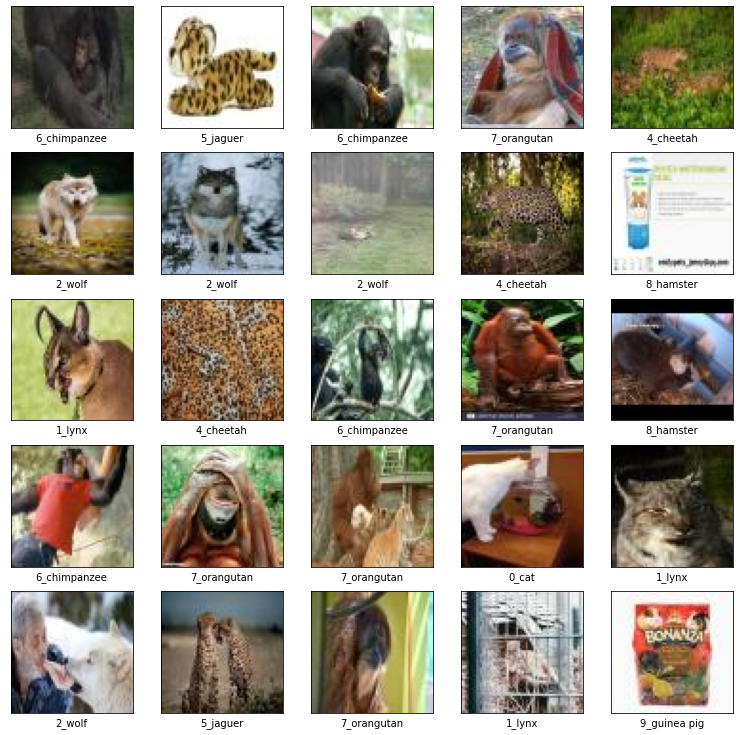

In [9]:
plt.figure(figsize=(13,13))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]) #Remove X axis
    plt.yticks([]) #Remove y axis
    plt.grid(False) #Remove grid
    imageId = random.randint(0,len(trainImages)-1)
    plt.imshow(plt.imread(trainImages[imageId]), cmap=plt.cm.binary)
    plt.xlabel(imageToCat(trainImages[imageId]))
plt.show()

Les images sont conrrectement labélisée nous pouvons passer à l'étape suivante

## Import des datasets

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./assets/ordered_image/train/",
    image_size=(64, 64),
    batch_size=32,
   ).cache().prefetch(buffer_size=AUTOTUNE) 

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./assets/ordered_image/test/",
    image_size=(64, 64),
    batch_size=32,
    ).cache().prefetch(buffer_size=AUTOTUNE)

Found 50000 files belonging to 10 classes.
Found 5000 files belonging to 10 classes.


## Construction du modèle

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64,64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
model.add(Dense(10,activation="softmax"))
model.summary()

model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               1

## Entrainement du modèle

Epoch 1/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.9776 - accuracy: 0.2650 - val_loss: 1.8518 - val_accuracy: 0.3292
Epoch 2/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.8183 - accuracy: 0.3322 - val_loss: 1.7015 - val_accuracy: 0.3836
Epoch 3/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6662 - accuracy: 0.3916 - val_loss: 1.6188 - val_accuracy: 0.4164
Epoch 4/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5269 - accuracy: 0.4428 - val_loss: 1.5923 - val_accuracy: 0.4382
Epoch 5/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3836 - accuracy: 0.4951 - val_loss: 1.6894 - val_accuracy: 0.4392
Epoch 6/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2412 - accuracy: 0.5485 - val_loss: 1.8172 - val_accuracy: 0.4368
Epoch 7/50
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1156 - accuracy: 0.5992 - val_loss: 1.8803 - val_ac

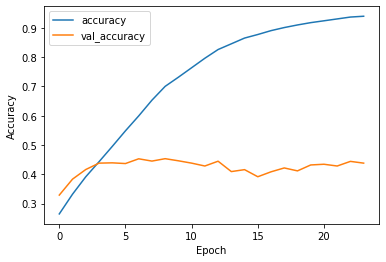

In [17]:
if trainModel :
    
    #Used to stop train earlier when there is no improvment. We stop when accuracy not up more than 1 percent on 2 epoch
    callbacks = [keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.01, patience=2,verbose=1,mode='max')]
    
    history = model.fit(train_ds, validation_data=test_ds, epochs=trainEpoch, batch_size=32,callbacks=callbacks)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
else :
    print("Entrainement du modèle annulé")

## Sauvegarde du modèle

In [18]:
if saveModel and trainModel:
    model.save("./model.h5")
else:
    print("Sauvegarde annulée due à la configuration")

## Chargement du modèle et tests réels

### Chargement du modèle depuis le fichier

In [19]:
# Utilisation du modèle que j'ai entrainé OU du modèle précédemment saugegardé

loadedModel  = tf.keras.models.load_model('./model.h5')


results = loadedModel.evaluate(train_ds, batch_size=32)
print("Model train accurency evaluated:", results)

results = loadedModel.evaluate(test_ds, batch_size=32)
print("Model test accurency evaluated:", results)

1563/1563 [==============================] - 6s 4ms/step - loss: 0.4125 - accuracy: 0.8983
Model train accurency evaluated: [0.4125012457370758, 0.8982800245285034]
157/157 [==============================] - 1s 4ms/step - loss: 3.7638 - accuracy: 0.4382
Model test accurency evaluated: [3.7638261318206787, 0.4381999969482422]


### Prédiction depuis les fichiers d'entrainement et de test

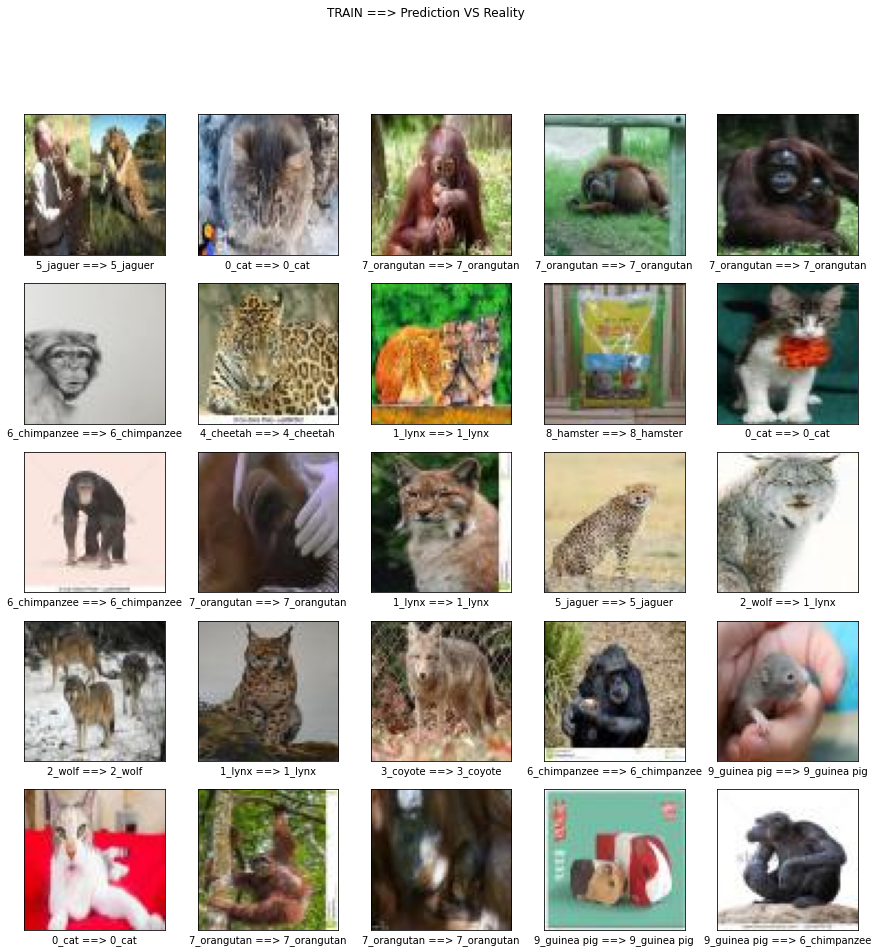

In [20]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('TRAIN ==> Prediction VS Reality ')
for i in range(25):
    imageId = random.randint(0,len(trainImages)-1)
    
    image = tf.keras.preprocessing.image.load_img(trainImages[imageId])
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions = loadedModel.predict(input_arr)
    classe = predictions.argmax(axis=-1)
    classeName = class_names[int(classe)]
    
    plt.subplot(5,5,i+1)
    plt.xticks([]) #Remove X axis
    plt.yticks([]) #Remove y axis
    plt.grid(False) #Remove grid
    plt.imshow(plt.imread(trainImages[imageId]), cmap=plt.cm.binary)
    plt.xlabel(classeName+" ==> " +imageToCat(trainImages[imageId]))
plt.show()

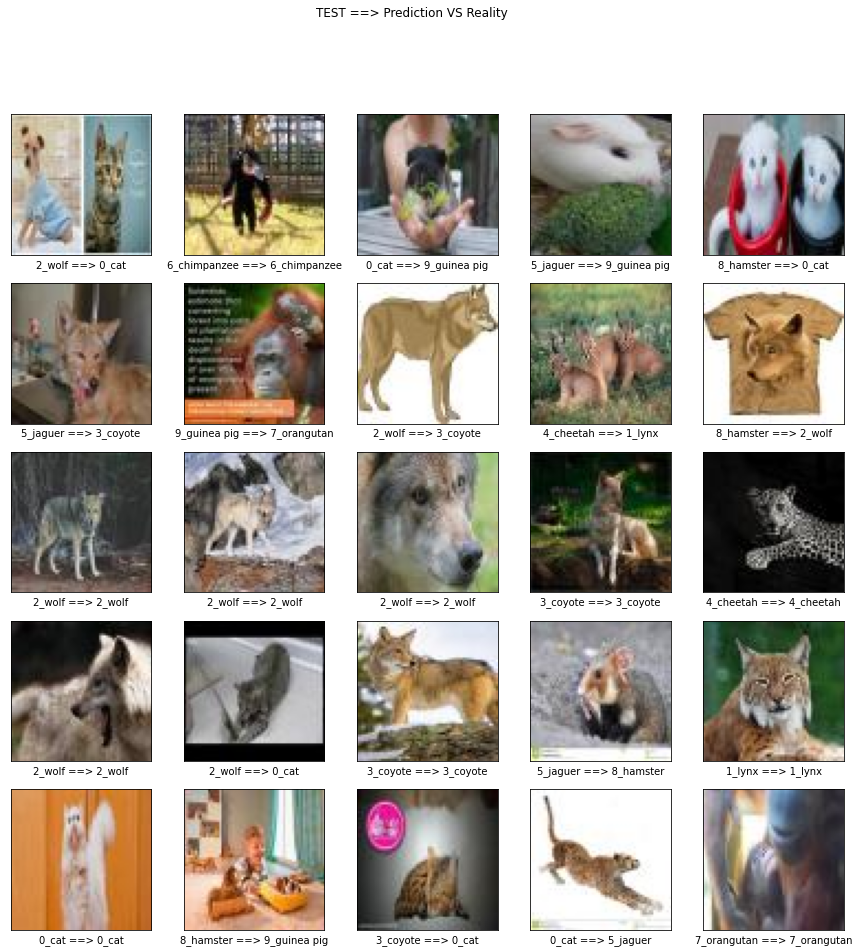

In [22]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('TEST ==> Prediction VS Reality ')
for i in range(25):
    imageId = random.randint(0,len(testImages)-1)
    
    image = tf.keras.preprocessing.image.load_img(testImages[imageId])
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions = loadedModel.predict(input_arr)
    classe = predictions.argmax(axis=-1)
    classeName = class_names[int(classe)]
    
    plt.subplot(5,5,i+1)
    plt.xticks([]) #Remove X axis
    plt.yticks([]) #Remove y axis
    plt.grid(False) #Remove grid
    plt.imshow(plt.imread(testImages[imageId]), cmap=plt.cm.binary)
    plt.xlabel(classeName+" ==> " +imageToCat(testImages[imageId]))
plt.show()